In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = self.pool(F.relu(self.conv5(x)))
        
        x = x.view(-1, 512)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [31]:
train_losses = []
test_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for _ in range(10))
    class_total = list(0. for _ in range(10))
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()
            
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    test_accuracies.append(epoch_accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

Epoch [1/10], Loss: 1.5771, Accuracy: 0.4729
Epoch [2/10], Loss: 1.2833, Accuracy: 0.5262
Epoch [3/10], Loss: 1.0992, Accuracy: 0.6134
Epoch [4/10], Loss: 0.9370, Accuracy: 0.6672
Epoch [5/10], Loss: 0.8093, Accuracy: 0.6955
Epoch [6/10], Loss: 0.7035, Accuracy: 0.7282
Epoch [7/10], Loss: 0.6127, Accuracy: 0.7278
Epoch [8/10], Loss: 0.5229, Accuracy: 0.7504
Epoch [9/10], Loss: 0.4405, Accuracy: 0.7507
Epoch [10/10], Loss: 0.3537, Accuracy: 0.7596


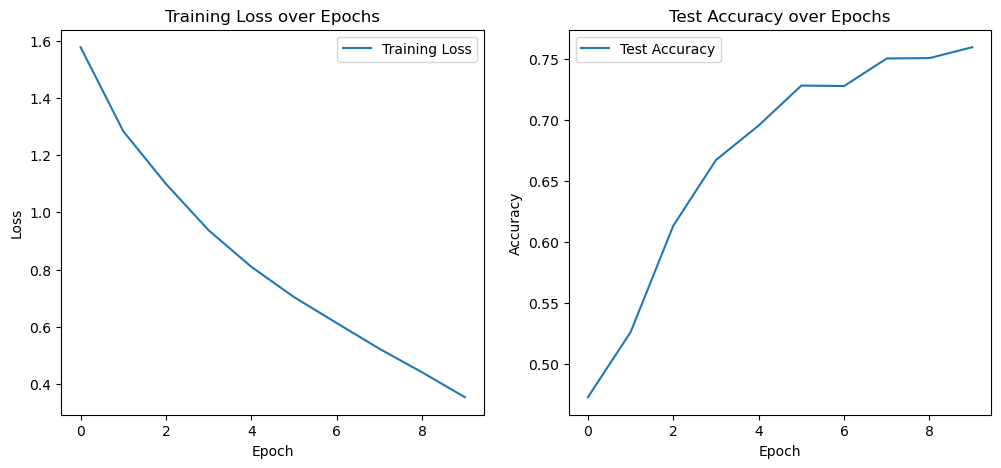

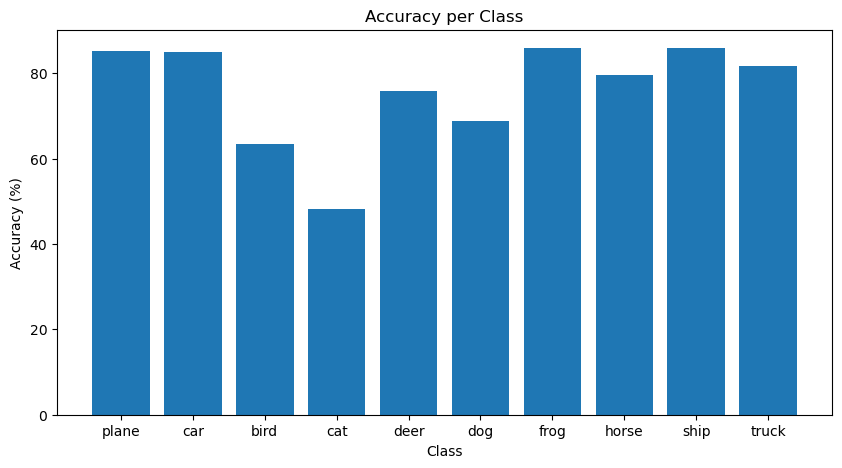

Accuracy of plane: 85.10 %
Accuracy of   car: 84.90 %
Accuracy of  bird: 63.50 %
Accuracy of   cat: 48.30 %
Accuracy of  deer: 75.80 %
Accuracy of   dog: 68.80 %
Accuracy of  frog: 85.80 %
Accuracy of horse: 79.70 %
Accuracy of  ship: 85.90 %
Accuracy of truck: 81.80 %


In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.figure(figsize=(10, 5))
plt.bar(classes, [100 * class_correct[i] / class_total[i] for i in range(10)])
plt.title('Accuracy per Class')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.show()

for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f'Accuracy of {classes[i]:>5s}: {accuracy:.2f} %')
